# 資料清洗

雖然在Taichung_591crawler/tc_get_591_data.jpynb中已經有對於爬取到的租屋資料做基本的清洗，不過，隨著在探索式分析的過程中，發現能進一步清洗資料以便於探索式分析，因此首先將資料進一步做清洗。

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = ['Heiti TC']

In [269]:
tc = pd.read_csv("../Taichung_591crawler/tc_cleaned_Rent_591.csv")

## 台中市各行政區租屋樣本數
根據下列結果發現，有部分行政區的租屋資料數很少，多半出現在人口數較少、工作機會較少的行政區；在實務上，深入研究這些行政區效益並不高，且在統計理論上，某一類的樣本太少代表著估計該類均值的偏誤可能性越大，因此，考慮將樣本數少於20筆的行政區刪除，包含「"外埔區", "大甲區", "大肚區", "梧棲區", "神岡區", "東勢區"」

In [270]:
tc.groupby("area").size()

area
中區       82
北區      759
北屯區     803
南區      275
南屯區     323
后里區      35
外埔區       1
大甲區       6
大肚區       4
大里區     134
大雅區      77
太平區     178
東勢區       2
東區      191
梧棲區      19
沙鹿區      87
清水區      48
潭子區      57
烏日區     145
神岡區      12
西區      345
西屯區    1053
豐原區      92
霧峰區      36
龍井區     140
dtype: int64

In [271]:
drop_area = "外埔區", "大甲區", "大肚區", "梧棲區", "神岡區", "東勢區"
tc1 = tc[~tc["area"].isin(drop_area)]
tc1

,kind,area,space,floor,top_floor,mrt,bd,pet,elevator,parking,balcony,price
0,整層住家,北屯區,28.0,2,15,0,1,0,1,0,0,29000
1,獨立套房,北屯區,12.6,6,7,0,1,0,1,0,0,8699
2,獨立套房,北屯區,13.0,6,7,0,1,0,1,0,0,11000
3,獨立套房,北屯區,13.0,2,7,0,1,0,1,0,0,11000
4,獨立套房,北區,13.0,12,12,0,0,0,1,0,0,11000
...,...,...,...,...,...,...,...,...,...,...,...,...
4899,獨立套房,北區,8.0,2,5,0,0,1,0,0,0,8500
4900,整層住家,北屯區,49.0,14,15,0,0,0,1,1,0,32000
4901,獨立套房,西區,12.0,3,5,0,1,0,0,0,1,12000
4902,獨立套房,北區,10.0,7,8,0,1,0,1,0,0,14000


## 台中市租屋類型
在591租屋網上，將租屋物件分為五類，分別為「分租套房, 整層住家, 獨立套房, 雅房, 其他」，在先前已經將"其他"類刪除，因其包含種類太多了，例如：廣告看板、店面；統計剩下的四類的樣本數，可以發現"雅房"的樣本數只有18筆，因此也將"雅房"資料刪除，著重在「分租套房, 整層住家, 獨立套房」三類。

In [272]:
tc1.groupby("kind").size()

kind
分租套房     124
整層住家    1995
獨立套房    2723
雅房        18
dtype: int64

In [273]:
drop_kind =tc1["kind"] == "雅房"
tc2 = tc1[~drop_kind]
tc2.reset_index(drop=True, inplace = True)
tc2

,kind,area,space,floor,top_floor,mrt,bd,pet,elevator,parking,balcony,price
0,整層住家,北屯區,28.0,2,15,0,1,0,1,0,0,29000
1,獨立套房,北屯區,12.6,6,7,0,1,0,1,0,0,8699
2,獨立套房,北屯區,13.0,6,7,0,1,0,1,0,0,11000
3,獨立套房,北屯區,13.0,2,7,0,1,0,1,0,0,11000
4,獨立套房,北區,13.0,12,12,0,0,0,1,0,0,11000
...,...,...,...,...,...,...,...,...,...,...,...,...
4837,獨立套房,北區,8.0,2,5,0,0,1,0,0,0,8500
4838,整層住家,北屯區,49.0,14,15,0,0,0,1,1,0,32000
4839,獨立套房,西區,12.0,3,5,0,1,0,0,0,1,12000
4840,獨立套房,北區,10.0,7,8,0,1,0,1,0,0,14000


## 台中市租屋樓層

觀察租屋資料的所在樓層分佈，發現其多數集中在2～5樓，除此之外，能發現大約每五個樓層為一個區間，比例會出現一次斷層式的減少，並且區間內的樓層比例相近，因此考慮將樓層每5樓設置一個區間，將樓層劃分為6類（以cat_floor表示），「1～5樓, 6～10樓, 10～15樓, 16～20樓, 20～30樓, 30樓以上」；除了所在樓層外，同時也將該租屋物件的最高樓層分為同樣的6類（以cat_top_floor表示）。後續的迴歸分析也將分別嘗試將樓層以分類變數建模與將樓層視為連續變數（即以真實樓層建模），並比較兩者的預測效果。

In [274]:
tc2["floor"].value_counts(normalize = True)

3     0.230070
2     0.156340
4     0.117307
5     0.114209
6     0.068154
7     0.048121
1     0.046675
8     0.033870
9     0.029740
11    0.029327
10    0.023751
12    0.023337
13    0.018381
14    0.017968
15    0.011152
18    0.005989
17    0.005576
19    0.003304
20    0.002272
16    0.002272
22    0.002272
21    0.002065
24    0.001859
23    0.001859
28    0.001446
25    0.001033
27    0.000826
26    0.000413
33    0.000207
32    0.000207
Name: floor, dtype: float64

In [275]:
# 新增樓層區間欄位 
tc2["cat_floor"]="cat_floor"
tc2["cat_top_floor"]="cat_top_floor"

tc2_reset_colums= ['kind'
               , 'area'
               , 'space'
               , 'floor'
               ,'cat_floor'
               , 'top_floor'
               , 'cat_top_floor'
               , 'mrt'
               , 'bd'
               , 'pet'
               , 'elevator'
               , 'parking'
               , 'balcony'
               , 'price'
               ]

tc2 = tc2[tc2_reset_colums]

/var/folders/j9/m4lgqs1n4555tzqjypnf73d80000gn/T/ipykernel_11388/1992331433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tc2["cat_floor"]="cat_floor"
/var/folders/j9/m4lgqs1n4555tzqjypnf73d80000gn/T/ipykernel_11388/1992331433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tc2["cat_top_floor"]="cat_top_floor"


In [276]:
floor_1_5 = tc2["floor"] <= 5
floor_6_10 = (tc2["floor"] > 5)&(tc2["floor"] <= 10)
floor_11_15 = (tc2["floor"] > 10)&(tc2["floor"] <= 15)
floor_16_20 = (tc2["floor"] > 15)&(tc2["floor"] <= 20)
floor_21_30 = (tc2["floor"] > 20)&(tc2["floor"] <= 30)
floor_30up = tc2["floor"] > 30


tc2.loc[floor_1_5, "cat_floor"]="1~5 樓"
tc2.loc[floor_6_10, "cat_floor"]="6~10 樓"
tc2.loc[floor_11_15, "cat_floor"]="11~15 樓"
tc2.loc[floor_16_20, "cat_floor"]="16~20 樓"
tc2.loc[floor_21_30, "cat_floor"]="20~30 樓"
tc2.loc[floor_30up, "cat_floor"]="30樓以上"

tc2.groupby("cat_floor").size()

cat_floor
11~15 樓     485
16~20 樓      94
1~5 樓      3218
20~30 樓      57
30樓以上         2
6~10 樓      986
dtype: int64

In [277]:
top_floor_1_5 = tc2["top_floor"] <= 5
top_floor_6_10 = (tc2["top_floor"] > 5)&(tc2["top_floor"] <= 10)
top_floor_11_15 = (tc2["top_floor"] > 10)&(tc2["top_floor"] <= 15)
top_floor_16_20 = (tc2["top_floor"] > 15)&(tc2["top_floor"] <= 20)
top_floor_21_30 = (tc2["top_floor"] > 20)&(tc2["top_floor"] <= 30)
top_floor_30up = tc2["top_floor"] > 30


tc2.loc[top_floor_1_5, "cat_top_floor"]="1~5 樓"
tc2.loc[top_floor_6_10, "cat_top_floor"]="6~10 樓"
tc2.loc[top_floor_11_15, "cat_top_floor"]="11~15 樓"
tc2.loc[top_floor_16_20, "cat_top_floor"]="16~20 樓"
tc2.loc[top_floor_21_30, "cat_top_floor"]="20~30 樓"
tc2.loc[top_floor_30up, "cat_top_floor"]="30樓以上"

tc2.groupby("cat_top_floor").size()

cat_top_floor
11~15 樓    1247
16~20 樓     224
1~5 樓      1562
20~30 樓     315
30樓以上        16
6~10 樓     1478
dtype: int64

In [278]:
# 將樓層區間轉為類別數據
tc2["cat_floor"] = tc2["cat_floor"].astype("category")
tc2["cat_top_floor"] = tc2["cat_top_floor"].astype("category")
tc2.dtypes

kind               object
area               object
space             float64
floor               int64
cat_floor        category
top_floor           int64
cat_top_floor    category
mrt                 int64
bd                  int64
pet                 int64
elevator            int64
parking             int64
balcony             int64
price               int64
dtype: object

In [279]:
# tc2.to_csv("tc_Regression.csv", index=False)
tc2

,kind,area,space,floor,cat_floor,top_floor,cat_top_floor,mrt,bd,pet,elevator,parking,balcony,price
0,整層住家,北屯區,28.0,2,1~5 樓,15,11~15 樓,0,1,0,1,0,0,29000
1,獨立套房,北屯區,12.6,6,6~10 樓,7,6~10 樓,0,1,0,1,0,0,8699
2,獨立套房,北屯區,13.0,6,6~10 樓,7,6~10 樓,0,1,0,1,0,0,11000
3,獨立套房,北屯區,13.0,2,1~5 樓,7,6~10 樓,0,1,0,1,0,0,11000
4,獨立套房,北區,13.0,12,11~15 樓,12,11~15 樓,0,0,0,1,0,0,11000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4837,獨立套房,北區,8.0,2,1~5 樓,5,1~5 樓,0,0,1,0,0,0,8500
4838,整層住家,北屯區,49.0,14,11~15 樓,15,11~15 樓,0,0,0,1,1,0,32000
4839,獨立套房,西區,12.0,3,1~5 樓,5,1~5 樓,0,1,0,0,0,1,12000
4840,獨立套房,北區,10.0,7,6~10 樓,8,6~10 樓,0,1,0,1,0,0,14000


# 資料分組探索

In [280]:
tc2 = pd.read_csv("tc_Regression.csv")
tc2

,kind,area,space,floor,cat_floor,top_floor,cat_top_floor,mrt,bd,pet,elevator,parking,balcony,price
0,整層住家,北屯區,28.0,2,1~5 樓,15,11~15 樓,0,1,0,1,0,0,29000
1,獨立套房,北屯區,12.6,6,6~10 樓,7,6~10 樓,0,1,0,1,0,0,8699
2,獨立套房,北屯區,13.0,6,6~10 樓,7,6~10 樓,0,1,0,1,0,0,11000
3,獨立套房,北屯區,13.0,2,1~5 樓,7,6~10 樓,0,1,0,1,0,0,11000
4,獨立套房,北區,13.0,12,11~15 樓,12,11~15 樓,0,0,0,1,0,0,11000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4837,獨立套房,北區,8.0,2,1~5 樓,5,1~5 樓,0,0,1,0,0,0,8500
4838,整層住家,北屯區,49.0,14,11~15 樓,15,11~15 樓,0,0,0,1,1,0,32000
4839,獨立套房,西區,12.0,3,1~5 樓,5,1~5 樓,0,1,0,0,0,1,12000
4840,獨立套房,北區,10.0,7,6~10 樓,8,6~10 樓,0,1,0,1,0,0,14000


In [281]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

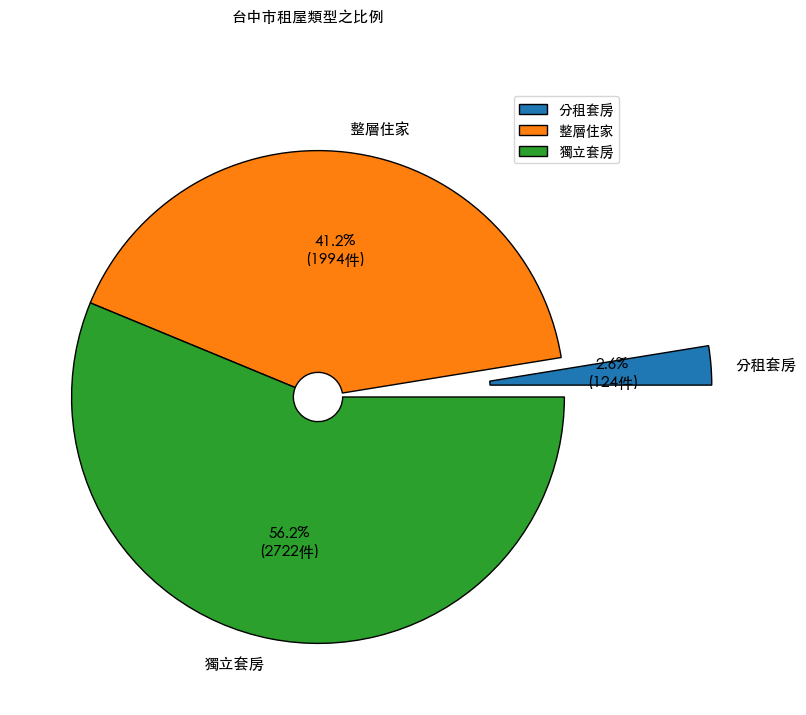

In [512]:
labels = tc2.groupby(["kind"]).size().index
values = tc2.groupby(["kind"]).size().values

def func(pct, allvals):
    counts = int(pct/100 * sum(allvals))
    return '{:.1f}%\n({:d}件)'.format(pct, counts)

def func1(pct):
    return func(pct, values)
    
fig = plt.figure(figsize = (8,8))
sub = fig.add_subplot(111)
sub.pie(values
        , labels = labels
        , labeldistance = 1.1
        , explode = [0.6,0,0]
        , autopct = func1
        , textprops = {'fontsize':11}
        , wedgeprops = {'edgecolor':'k', 'width' : 0.9}
       )
sub.legend(loc='upper right')

fig.suptitle("台中市租屋類型之比例", fontsize = 11)
plt.show()

In [16]:
kind_price = tc2.groupby(["kind"], as_index = False)
kind_price["price"].mean().sort_values(by = "price")

,kind,price
0,分租套房,7291.016129
2,獨立套房,8869.908189
1,整層住家,26541.241604


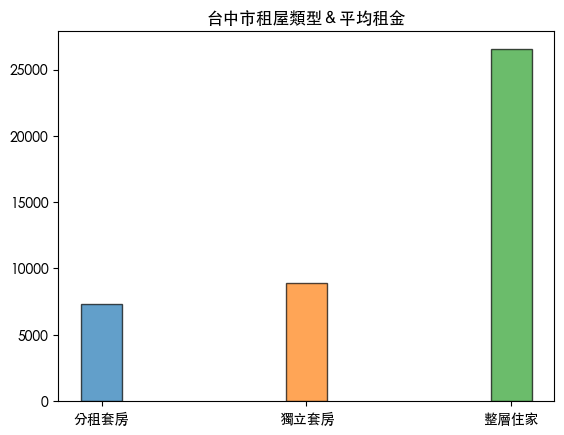

In [480]:
x = kind_price["price"].mean().sort_values(by = "price")["kind"]
y = kind_price["price"].mean().sort_values(by = "price")["price"]

fig = plt.figure()
sub = fig.add_subplot(111)
sub.bar(x = x[0], height = y[0], width = 0.2, alpha = 0.7, edgecolor = 'k')
sub.bar(x = x[2], height = y[2], width = 0.2, alpha = 0.7, edgecolor = 'k')
sub.bar(x = x[1], height = y[1], width = 0.2, alpha = 0.7, edgecolor = 'k')

# sub.set_ylabel("平均租金", fontsize = 12, rotation = 0, loc = 'top') 
sub.set_title('台中市租屋類型＆平均租金')
plt.show()

In [18]:
area_price = tc2.groupby(["area"], as_index = False)
area_price["price"].mean().sort_values(by = "price")

,area,price
17,霧峰區,8165.485714
18,龍井區,9065.884892
10,沙鹿區,10773.264368
5,后里區,11085.657143
16,豐原區,11171.565217
0,中區,11319.304878
1,北區,11671.038411
7,大雅區,12088.297297
12,潭子區,12748.089286
6,大里區,12974.473684


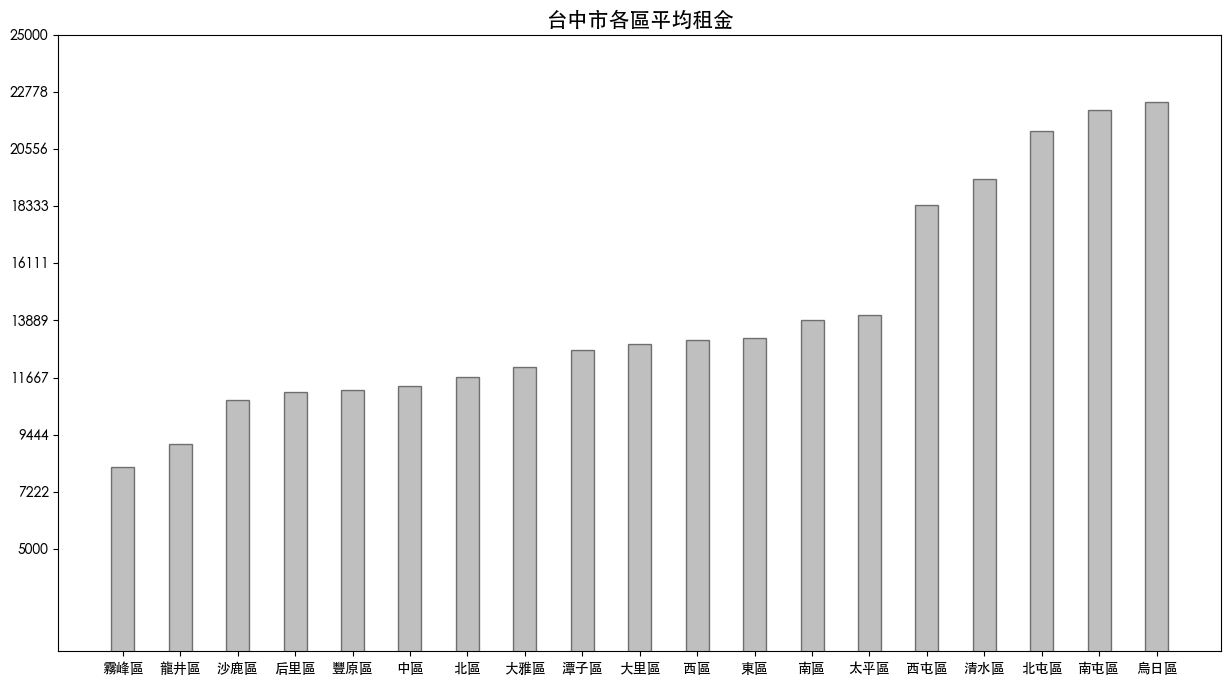

In [467]:
x = area_price["price"].mean().sort_values(by = "price")["area"]
y = area_price["price"].mean().sort_values(by = "price")["price"]

fig = plt.figure(figsize=(15,8))
sub = fig.add_subplot(111)

sub.bar(x = x, height = y, alpha = 0.5, width = 0.4, edgecolor = 'k', color = 'grey')
sub.set_ylim([1000, 25000])
sub.set_yticks(np.linspace(5000,25000,10))
sub.set_title("台中市各區平均租金", fontsize = 15) 
plt.show()

In [330]:
# 由於烏日區沒有分租套房 為畫圖方便 自行添加一筆資料
kind_area_price = tc2.groupby(["kind", "area"], as_index = False)[["price"]].mean()
_ = kind_area_price[kind_area_price['kind']=='分租套房']
add = pd.DataFrame({'kind':['分租套房'],'area':['烏日區'],'price':[None]})
_ = pd.concat([_,add]).reset_index(drop = True).sort_values(by = 'area')
_

,kind,area,price
0,分租套房,中區,5500.000000
1,分租套房,北區,7673.333333
2,分租套房,北屯區,7136.363636
3,分租套房,南區,7000.000000
4,分租套房,南屯區,9633.333333
5,分租套房,后里區,6500.000000
6,分租套房,大里區,5480.000000
7,分租套房,大雅區,8960.000000
8,分租套房,太平區,5920.000000
9,分租套房,東區,5400.000000


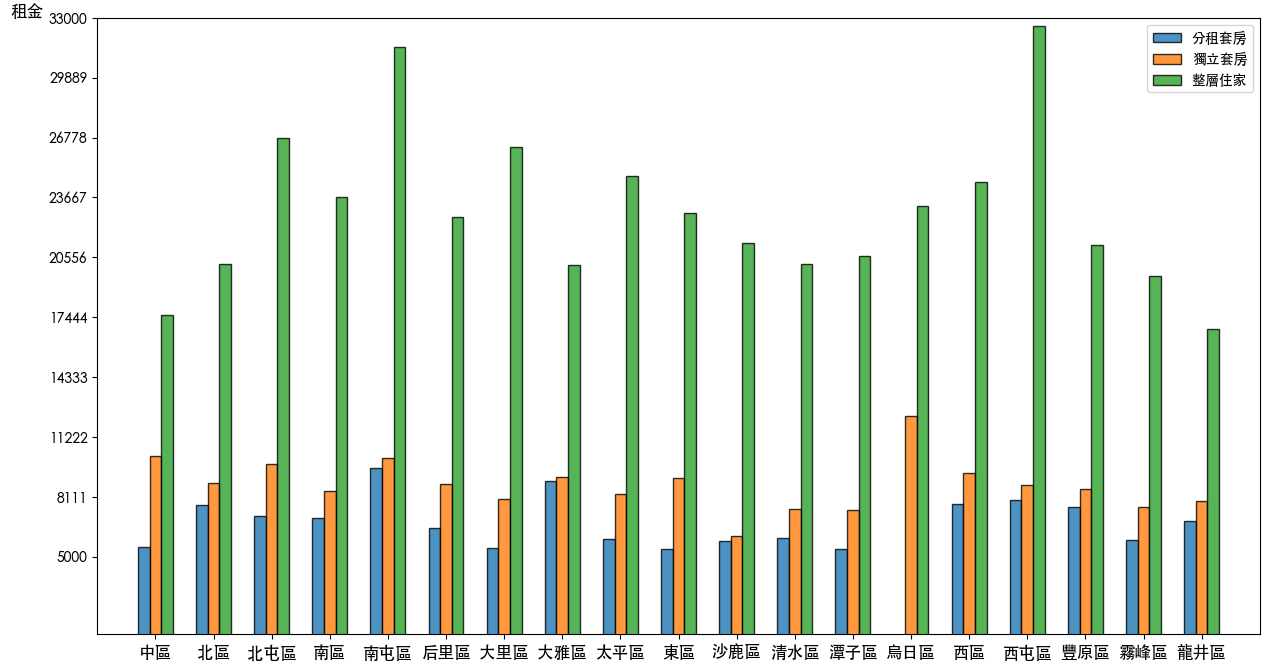

In [513]:
kind_area_price = tc2.groupby(["kind", "area"], as_index = False)[["price"]].mean()
kind_area_price


xlabels = _['area']
# len(xlabels)

x = np.arange(1,20)
y1 = _["price"]
y2 = kind_area_price[kind_area_price["kind"]=="獨立套房"]["price"]
y3 = kind_area_price[kind_area_price["kind"]=="整層住家"]["price"]


fig = plt.figure(figsize=(15,8))

sub = fig.add_subplot(111)
sub.bar(x = x-0.2, height = y1, width = 0.2, alpha = 0.8, edgecolor = 'k')
sub.bar(x = x, height = y2, width = 0.2, alpha = 0.8, edgecolor = 'k')    
sub.bar(x = x+0.2, height = y3, width = 0.2, alpha = 0.8, edgecolor = 'k')     


sub.set_xlim([0,20])
sub.set_ylim([1000, 33000])
sub.set_xticks(np.linspace(1,19,19))
sub.set_yticks(np.linspace(5000,33000,10))
sub.set_xticklabels(xlabels ,fontsize=12,rotation=0)
sub.set_ylabel("租金",fontsize=12,rotation=0, loc = 'top')
sub.legend(['分租套房', '獨立套房','整層住家'])

plt.show()

In [518]:
kind_area_price = tc2.groupby(["kind", "area"], as_index = False)[["price"]].mean().sort_values(by = "price")
kind_area_price[kind_area_price["kind"]=="分租套房"]

,kind,area,price
9,分租套房,東區,5400.000000
12,分租套房,潭子區,5400.000000
6,分租套房,大里區,5480.000000
0,分租套房,中區,5500.000000
10,分租套房,沙鹿區,5828.571429
16,分租套房,霧峰區,5850.000000
8,分租套房,太平區,5920.000000
11,分租套房,清水區,6000.000000
5,分租套房,后里區,6500.000000
17,分租套房,龍井區,6833.166667


In [520]:
kind_area_price[kind_area_price["kind"]=="獨立套房"]

,kind,area,price
47,獨立套房,沙鹿區,6069.358491
49,獨立套房,潭子區,7429.900000
48,獨立套房,清水區,7499.500000
54,獨立套房,霧峰區,7577.161290
55,獨立套房,龍井區,7886.491228
43,獨立套房,大里區,7979.769231
45,獨立套房,太平區,8285.788991
40,獨立套房,南區,8424.502959
53,獨立套房,豐原區,8506.225806
52,獨立套房,西屯區,8740.647651


In [521]:
kind_area_price[kind_area_price["kind"]=="整層住家"]

,kind,area,price
36,整層住家,龍井區,16847.315789
18,整層住家,中區,17564.071429
35,整層住家,霧峰區,19600.000000
25,整層住家,大雅區,20134.900000
29,整層住家,清水區,20211.088889
19,整層住家,北區,20231.173684
30,整層住家,潭子區,20643.304348
34,整層住家,豐原區,21219.900000
28,整層住家,沙鹿區,21288.814815
23,整層住家,后里區,22666.666667


In [522]:
tc2.groupby("elevator")[["price"]].mean()

,price
elevator,
0,10785.363116
1,19113.494509


In [523]:
tc2.groupby("parking")[["price"]].size()
tc2.groupby("parking")[["price"]].mean()

,price
parking,
0,14498.684846
1,25679.187679


In [524]:
tc2.groupby("bd")[["price"]].size()
tc2.groupby("bd")[["price"]].mean()

,price
bd,
0,18051.133971
1,15432.135173


In [525]:
tc2.groupby("mrt")[["price"]].size()
tc2.groupby("mrt")[["price"]].mean()

,price
mrt,
0,15077.904258
1,19789.884072


In [526]:
tc2.groupby("pet")[["price"]].size()
tc2.groupby("pet")[["price"]].mean()

,price
pet,
0,16211.060568
1,15646.365006


In [527]:
tc2.groupby("balcony")[["price"]].size()
tc2.groupby("balcony")[["price"]].mean()

,price
balcony,
0,17441.438296
1,8939.035620


In [528]:
tc2.groupby("cat_floor")[["price"]].size()
tc2.groupby("cat_floor")[["price"]].mean()

,price
cat_floor,
11~15 樓,25973.280412
16~20 樓,29419.914894
1~5 樓,12945.178682
20~30 樓,37841.982456
30樓以上,129250.000000
6~10 樓,18834.718053
